## Anime Recommender Engine
### *I'm looking for an anime, have you seen it?*

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

In [2]:
import numpy as np

For the anime data that contains three data sets ( User List, Anime List, and User \& Anime List), found on [Kaggle](https://www.kaggle.com/azathoth42/myanimelist), we can start out by importing the data and doing some data exploration to see what variables we should keep. Starting with the User List:

In [3]:
users = pd.read_csv("UserList.csv")
users.shape

(302675, 17)

For the users data, we can begin by visualizing the missing values and either imputing them (if it is not a big proportion of the data) or dropping them altogether.

In [4]:
conda install -c conda-forge missingno

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import missingno as msno

<AxesSubplot:>

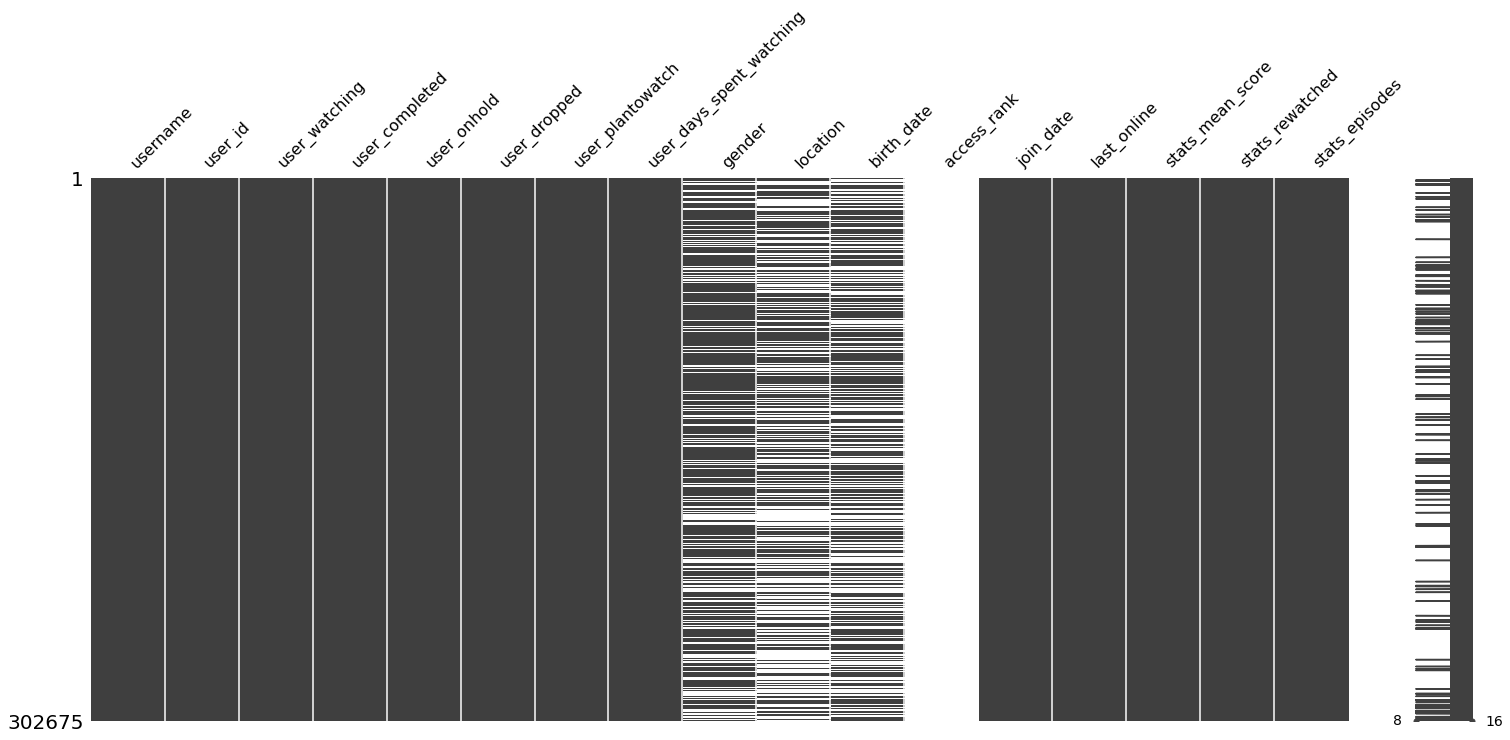

In [6]:
msno.matrix(users)

In the plot above, we see that there are quite a few missing values for variables *gender*, *location*, *birth_date*, and *access_rank*. There may be a few other variables with missing values, but the ones we just listed are the most prominent. We want to see just how many observations are missing for each variable.

In [7]:
round((users[users.columns[users.isnull().any()].tolist()].isnull().sum()*100)/len(users),2)

username              0.00
gender               28.04
location             48.20
birth_date           44.25
access_rank         100.00
join_date             0.04
last_online           0.04
stats_mean_score      0.04
stats_rewatched       0.04
stats_episodes        0.04
dtype: float64

We see that out of the four variables we mentioned before, only *gender* should be imputed, as its missing value percentage does not exceed 30\%. *access_rank* has no values recorded at all, so it may be dropped. For the other two variables, the rows with missing values may be removed. We wish to keep variables *location* and *birth_date*, as these may be integral to the recommender engine based on user descriptives.

Other variables, where the percent of missing values is very small (<1\%), we may impute these (if there are still missing values after rows are deleted).

In [8]:
users.drop("access_rank", axis=1, inplace=True)

In [9]:
users.dropna(subset=["birth_date","location"],inplace=True)

In [10]:
round((users[users.columns[users.isnull().any()].tolist()].isnull().sum()*100)/len(users),2)

username    0.00
gender      3.55
dtype: float64

After dropping rows with large amounts of missing values, we only need to adjust *gender*. We will not be imputing *username*, but rather dropping the variable altogether, as we have *user_id*, which gives us the necessary identification for each user. For *gender*, we will drop the NAs as well since only a small percentage of values are missing.

In [11]:
users.drop("username", axis=1, inplace=True)
users.dropna(subset=["gender"],inplace=True)

In [12]:
users.shape

(119625, 15)

After the initial data cleaning, we are left with 15 variables (17 originally) and 119,624 users (302,675 originally). We can further assess data and decide what information we need. We need not keep the following variables to build a recommendation engine: *user_watching*, *user_onhold*, *user_dropped*, *user_plantowatch*, and *stats_rewatched*.  

In [13]:
users.drop(["user_watching","user_onhold","user_dropped","user_plantowatch","stats_rewatched"], 
           axis=1, inplace=True)

We can now move on to validating the data. We know that the number of days spent watching anime numst be smaller than the days between birth date and join date, so we will double check to make sure that the observation meet this criterion.

In [14]:
users

,user_id,user_completed,user_days_spent_watching,gender,location,birth_date,join_date,last_online,stats_mean_score,stats_episodes
0,2255153,49,55.31,Female,"Chennai, India",1990-04-29,2013-03-03,2014-02-04 01:32:00,7.43,3391.0
1,1897606,396,118.07,Female,Manila,1995-01-01,2012-12-13,1900-05-13 02:47:00,6.78,7094.0
2,37326,195,83.70,Male,"Detroit,Michigan",1991-08-01,2008-02-13,1900-03-24 12:48:00,6.15,4936.0
3,228342,414,167.16,Male,"Nayarit, Mexico",1990-12-14,2009-08-31,2014-05-12 16:35:00,8.27,10081.0
5,327311,5,15.20,Female,"Malaysia, Kuantan",1998-08-24,2010-05-10,2012-10-18 19:06:00,9.70,920.0
...,...,...,...,...,...,...,...,...,...,...
302652,1396285,116,49.87,Female,"nhollywood, california",1998-07-18,2012-07-14,2017-02-14 00:30:00,8.86,3027.0
302655,381078,1,0.49,Male,"Russia, Novokuznetsk",1990-08-02,2010-09-09,2015-06-03 10:59:00,8.00,27.0
302657,2478991,103,47.94,Female,Belgium,1995-10-17,2013-04-24,2016-12-18 08:41:00,7.40,2906.0
302671,3975907,239,86.88,Male,"Latvia, Riga",1998-11-18,2014-07-30,2018-05-24 21:34:46,8.98,5313.0


In [15]:
d1 = users[["birth_date"]].to_numpy()
d2 = users[["join_date"]].to_numpy()
d3 = users[["user_days_spent_watching"]].to_numpy()
d4 = users[["last_online"]].to_numpy()

In [16]:
d1 = np.array(d1, dtype='datetime64[D]')
d2 = np.array(d2, dtype='datetime64[D]')
d4 = np.array(d4, dtype='datetime64[D]')

In [17]:
join_birth_diff = np.float64(d2-d1)

In [18]:
a = []
for i in range(len(join_birth_diff)):
    if join_birth_diff[i] < d3[i]:
        a.append(i)

In [19]:
len(a)

458

There are 458 rows where the criterion is not met - we will delete these observations.

In [20]:
users.reset_index(drop=True, inplace=True)
users.drop(a, inplace=True)

In [21]:
users

,user_id,user_completed,user_days_spent_watching,gender,location,birth_date,join_date,last_online,stats_mean_score,stats_episodes
0,2255153,49,55.31,Female,"Chennai, India",1990-04-29,2013-03-03,2014-02-04 01:32:00,7.43,3391.0
1,1897606,396,118.07,Female,Manila,1995-01-01,2012-12-13,1900-05-13 02:47:00,6.78,7094.0
2,37326,195,83.70,Male,"Detroit,Michigan",1991-08-01,2008-02-13,1900-03-24 12:48:00,6.15,4936.0
3,228342,414,167.16,Male,"Nayarit, Mexico",1990-12-14,2009-08-31,2014-05-12 16:35:00,8.27,10081.0
4,327311,5,15.20,Female,"Malaysia, Kuantan",1998-08-24,2010-05-10,2012-10-18 19:06:00,9.70,920.0
...,...,...,...,...,...,...,...,...,...,...
119620,1396285,116,49.87,Female,"nhollywood, california",1998-07-18,2012-07-14,2017-02-14 00:30:00,8.86,3027.0
119621,381078,1,0.49,Male,"Russia, Novokuznetsk",1990-08-02,2010-09-09,2015-06-03 10:59:00,8.00,27.0
119622,2478991,103,47.94,Female,Belgium,1995-10-17,2013-04-24,2016-12-18 08:41:00,7.40,2906.0
119623,3975907,239,86.88,Male,"Latvia, Riga",1998-11-18,2014-07-30,2018-05-24 21:34:46,8.98,5313.0


In [22]:
d1 = users[["birth_date"]].to_numpy()
d2 = users[["join_date"]].to_numpy()
d4 = users[["last_online"]].to_numpy()

We know that since the website MyAnimeList was launched on November 6, 2004 any observations where the last date online occurs before then are invalid. Thus, we will discard of these. After that, we won't have the need to keep the variable *last_online*. This resulted in 36,198 observations being dropped.

In [23]:
users['last_online'] = pd.to_datetime(users['last_online'])  
b = (users['last_online'] > '2004-11-05') 
users = users[b]
users.reset_index(drop=True, inplace=True)
users.drop(["last_online"], axis=1, inplace=True)

We also noticed that the variable *location* does not have consistent observations recorded - it seems as though users were able to input any word for their location. This means that there are locations that do not exist, country names, city names, or a combination of the two. We will transform this variable to only contain country names, where they are given/exist. First, split the variable by whatever punctuation was used and then extract country names using the **pycountry** library.

In [24]:
# pip install pycountry
import pycountry as pc

In [25]:
uLoc = users['location'].str.split(',', expand=True)
uLoc

,0,1,2,3,4,5,6
0,Chennai,India,None,None,None,None,None
1,Nayarit,Mexico,None,None,None,None,None
2,Malaysia,Kuantan,None,None,None,None,None
3,Norberg Sweden,None,None,None,None,None,None
4,Nebraska,None,None,None,None,None,None
...,...,...,...,...,...,...,...
82964,nhollywood,california,None,None,None,None,None
82965,Russia,Novokuznetsk,None,None,None,None,None
82966,Belgium,None,None,None,None,None,None
82967,Latvia,Riga,None,None,None,None,None


In [26]:
for column in uLoc:
    uLoc[column] = uLoc[column].str.strip()
uLoc.fillna("Other",inplace=True)

In [27]:
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
def findState(state_name):
    for i in us_states:
        if i.lower() in state_name.lower():
           return ("United States")
    return (state_name)
for column in uLoc:
    uLoc[column] = uLoc[column].apply(lambda row: findState(row))

In [28]:
def findCountry (country_name):
    try:
        return pc.countries.get(name=country_name).name
    except:
        return ("Other")
for column in uLoc:
    uLoc[column] = uLoc[column].apply(lambda row: findCountry(row))

In [29]:
cnames=[]
for i in range(len(uLoc.index)):
    if True in list(uLoc.iloc[i]!='Other'):
        cnames.append(uLoc.iloc[i][uLoc.iloc[i]!='Other'].values[0])
    else:
        cnames.append('Other')

In [30]:
users['country']=cnames
users.drop(['location'], axis=1, inplace=True)
users

,user_id,user_completed,user_days_spent_watching,gender,birth_date,join_date,stats_mean_score,stats_episodes,country
0,2255153,49,55.31,Female,1990-04-29,2013-03-03,7.43,3391.0,India
1,228342,414,167.16,Male,1990-12-14,2009-08-31,8.27,10081.0,Mexico
2,327311,5,15.20,Female,1998-08-24,2010-05-10,9.70,920.0,Malaysia
3,326733,3,4.32,Male,1991-03-15,2010-05-09,10.00,251.0,Other
4,5927342,4,2.09,Male,1984-11-16,2016-12-25,7.40,121.0,United States
...,...,...,...,...,...,...,...,...,...
82964,1396285,116,49.87,Female,1998-07-18,2012-07-14,8.86,3027.0,United States
82965,381078,1,0.49,Male,1990-08-02,2010-09-09,8.00,27.0,Other
82966,2478991,103,47.94,Female,1995-10-17,2013-04-24,7.40,2906.0,Belgium
82967,3975907,239,86.88,Male,1998-11-18,2014-07-30,8.98,5313.0,Latvia


In [31]:
[sum(users['country']=='Other'),sum(users['country']!='Other')]

[37021, 45948]

In [32]:
users.replace("United States", "United States of America",inplace=True)

There are 45,948 recognized country names in the dataset and the rest (37,021) are not known (perhaps the country name was not given and/or mispelled, e.g., "nhollywood" is in the US, but we will not be doing very thorough word mining, but only keeping obvious country names) - this is a large amount and so we will keep this data. Perhaps the individuals who input something "odd" for their location are similar in some way.

Now that the data has been cleaned a bit more, we can move on to visualizing each variable/combinations of them to better understand the users of the platform.

In [33]:
from matplotlib import pyplot as plt
import math

In [34]:
import seaborn as sns
sns.set_theme(style="white", palette="pastel")

We will now check the distribution of the data for the numeric variables to see if any outliers exist and if those can be deleted. We want to check the ages of the users when they first joined, so we can drop users whose age seems like an outlier.

In [35]:
users["age"] = (pd.to_datetime(users["join_date"])-pd.to_datetime(users["birth_date"]))/np.timedelta64(1, 'Y')

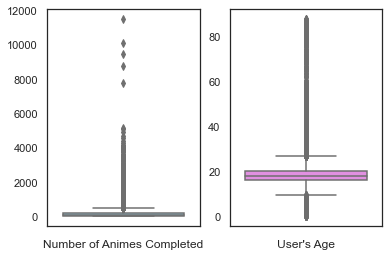

In [36]:
fig, ax = plt.subplots(1,2)

sns.boxplot(y=users["user_completed"], color="skyblue", ax=ax[0]).set(xlabel="Number of Animes Completed",ylabel="");
sns.boxplot(y=users["age"], color="violet", ax=ax[1]).set(xlabel="User's Age",ylabel="");

plt.show()

It seems that there are a few outliers in both variables that need to be dealt with. We can use the z-score approach to drop those observations that lie further than 3 standard deviations away from the mean (i.e., where $\pm z>3$, assuming normal distribution).

In [37]:
from scipy import stats 

In [38]:
z_uc = np.abs(stats.zscore(users['user_completed']))
z_age = np.abs(stats.zscore(users['age']))
print(sum(z_uc > 3),sum(z_age > 3))

1417 834


We find that there are 1,417 observations (animes completed) and 834 (age) that can be considered outliers - these will be removed from the dataset. Also, MyAnimeList states that the users need to be over the age of 13 (and 16 in Europe) to join the website (or require parental approval, which we have no way of verifying) [MyAnimeList](https://myanimelist.net/membership/terms_of_use), so we can drop users whose age is under 13.

In [39]:
users.drop(np.where((z_uc>3)|(z_age>3))[0],inplace = True)
users.reset_index(drop=True, inplace=True)

Same should be done for the remaining numeric variables.

In [40]:
z_udsw = np.abs(stats.zscore(users['user_days_spent_watching']))
users.drop(np.where(z_udsw>3)[0],inplace = True)
users.reset_index(drop=True, inplace=True)
z_sms = np.abs(stats.zscore(users['stats_mean_score']))
users.drop(np.where(z_sms>3)[0],inplace = True)
users.reset_index(drop=True, inplace=True)
z_se = np.abs(stats.zscore(users['stats_episodes']))
users.drop(np.where(z_se>3)[0],inplace = True)
users.reset_index(drop=True, inplace=True)

In [41]:
users.drop(users[users['age']<13].index, inplace=True)
users.reset_index(drop=True, inplace=True)

In [42]:
users.shape

(72707, 10)

After dropping outliers, we are left with 72,707 observations out of 82,969 (87.6\% of the original amount).

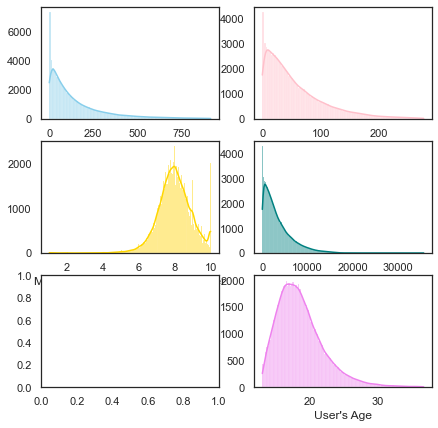

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))

sns.histplot(users["user_completed"], kde=True, color="skyblue", ax=axs[0, 0]).set(xlabel="Number of Animes Completed",ylabel="");
sns.histplot(users["user_days_spent_watching"], kde=True, color="pink", ax=axs[0, 1]).set(xlabel="Number of Days Spent Watching",ylabel="");
sns.histplot(users["stats_mean_score"], kde=True, color="gold", ax=axs[1, 0]).set(xlabel="Mean Anime Score Given by a User",ylabel="");
sns.histplot(users["stats_episodes"], kde=True, color="teal", ax=axs[1, 1]).set(xlabel="Number of Episodes Completed",ylabel="");
sns.histplot(users["age"], kde=True, color="violet", ax=axs[2, 1]).set(xlabel="User's Age",ylabel="");

plt.show()

The data looks fairly clean, so we can move onto exploring any interesting patterns and making observstions that will help us understand users.

Text(0.5, 1.0, 'Count of Users by Gender')

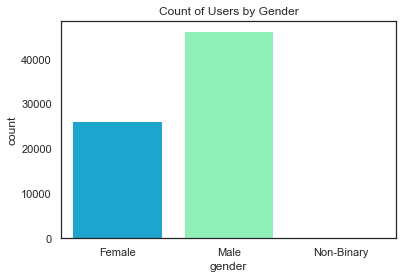

In [44]:
sns.countplot(x='gender',data=users, palette='rainbow')
plt.title("Count of Users by Gender")

We see that the users are primarily male, so our recommender engine will perform slighly better for males than females (47,202 males vs 27,793 females). However, since the sample sizes are large for both groups, this is negligible. There is not a lot of represantation for the non-binary gender, with very few users (249) in that group. Next, we'll take a look at where the users are located (or at least report they are located).

In [45]:
# pip install geopandas
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
table = world.merge(users[users.country!="Other"], how="left", left_on=['name'], right_on=['country'])

In [ ]:
plt.figure(figsize=(40,16))
ax1 = plt.subplot(211)
table.plot("user_days_spent_watching",ax=ax1,
           legend=True,legend_kwds={"label":"# of Days Spent Watching"},
           edgecolor='0',cmap=plt.cm.Blues,missing_kwds={"color": "grey","hatch":"."})
plt.title("User Watching Animes by Country");

ax2 = plt.subplot(212)
table.plot("user_completed",ax=ax2,
           legend=True,legend_kwds={"label":"# of Animes User Completed"},
           edgecolor='0',cmap=plt.cm.Greens,missing_kwds={"color": "grey","hatch":"."})
plt.title("User Completed Animes by Country");

Some of the location data is missing (since certain locations were not identified), but we see that the most views come from South America, parts of Africa, USA, and Australia. It also seems that the USA, Poland, and Phillippines are the top 3 countries in terms of the number of views.

In [ ]:
cntrs = table.groupby(['country']).size().reset_index(name='Number of Users').sort_values(by='Number of Users', ascending=False)[0:24]
ax = cntrs.plot.bar(x='country', xlabel = '', figsize=(20,8))

In [ ]:
sns.stripplot(x=users["gender"],y=pd.to_numeric(users["age"]))

Seems like the older part of the users (30+) are mostly males, with fewer females. The non-binary users are mostly younger individuals, primarily around the age of 18. We are happy with the way this current dataset looks - it has been cleaned up, outliers have been discarded, and observations were made about the users. We will move on to the next dataset.

In [ ]:
animes = pd.read_csv("AnimeList.csv")
animes.shape

In [ ]:
msno.matrix(animes)

In [ ]:
round((animes[animes.columns[animes.isnull().any()].tolist()].isnull().sum()*100)/len(animes),2)

Variables such as *title_japanese*, *title_synonyms*, *image_url*, *background*, *related*, *opening_theme*, and *ending_theme* can all be dropped either because they are substitutes/related to other variables (e.g., title variables) or because they might be too complicated to clean up/reqquire more complex methods that are out of scope (e.g., *background*, *image_url*).